# 프로젝트 : 모든 장르 간 편향성 측정해 보기

## 라이브러리 버전을 확인

In [3]:
import konlpy
import gensim
import sklearn
import seaborn

print(konlpy.__version__)
print(gensim.__version__)
print(sklearn.__version__)
print(seaborn.__version__)

0.5.2
4.1.2
1.0
0.11.2


In [5]:
from tqdm import tqdm, trange

In [4]:
import os
from konlpy.tag import Okt
from nltk.tokenize import sent_tokenize
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np
import pandas as pd

## STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

In [6]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [8]:
import os

def read_synopsis(file_name):
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as file:
        for i in range(1):
            print(file.readline(), end='')

In [9]:
read_synopsis(genre_txt[0])

시간과 지명을 알 수 없는 한국의 어느 가상 도시. 산성비로 오염된 이 도시에 잊고 싶은 기억만을 지워주는 망각의 바이러스가 존재한다는 소문이 떠돌기 시작하고, 고통스런 기억을 잊기 위해 사람들은 그곳으로 모여든다. 어두운 기억을 지닌 안나 역시 망각의 바이러스를 찾아온다. 그녀를 기다리는 사람은 바이러스 가이드 유키와 고아 출신의 여행사 소속 택시 운전사 K. 나비 떼가 바이러스 지역으로 인도한다는 정보에 따라 산성비의 위험을 무릅쓰고 세 사람이 도착한 곳은 거대한 공사현장. 그곳에서 안나는 수많은 나비떼, 가이드들, 또한 그들이 흔들어대는 구슬소리 등의 기이한 분위기로 인해 자신의 아픈 기억을 환각 속에서 보게 된다. 한편 가이드인 유키가 납중독이 걸린 상태임에도 임신 7개월로 아이를 낳으려 한다는 것을 알게 된 안나는 그녀를 떨쳐 버리려 하나, 인연의 끈은 유키를 떨쳐버리게 하지 않는다. 유키는 산성비에 노출된 안나를 정성껏 씻겨주고 자신의 캡슐하우스에서 놀라운 영상을 보여준다. 아픈 기억을 자신은 잊어버리려 하지만 그래도 누군가는 기억해 주길 바랬던 한 소녀가 찍은 셀프비디오. 또한 망각의 바이서스로 기억을 버리고 완전히 새로 태어난 사람들이 남기고 간 여권들. 그러면서 안나의 기억을 자신이 간직해주겠다고 한다. 안나는 오로지 망각을 향해서만 돌진하는 자신을 뒤돌아보게 되고 어린 유케에게 묘한 우정을 느낀다.


In [86]:
def read_files(file_list):
    texts = []
    for file_name in tqdm(file_list):
        with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as file:
            texts.append(file.read())
    return texts

In [87]:
texts = read_files(genre_txt)

100%|██████████| 21/21 [00:00<00:00, 35.24it/s]


In [12]:
from nltk.tokenize import sent_tokenize

In [13]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /aiffel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
len(texts)

21

In [37]:
def preprocess_texts_korean(texts):
    okt = Okt()
    processed_texts = []
    for text in tqdm(texts):
        genre_texts = []
        sentences = sent_tokenize(text)
        for sentence in sentences:
            words = []
            # 명사만 추출
            tokenlist = okt.pos(sentence, stem=True, norm=True)
            for word in tokenlist:
                if word[1] in ["Noun"]:
                    words.append(word[0])
        
            genre_texts.append(words)

        processed_texts.append(genre_texts)
    
    return processed_texts

In [42]:
processed_texts = preprocess_texts_korean(texts)

100%|██████████| 21/21 [12:33<00:00, 35.89s/it]


In [46]:
len(processed_texts)

21

In [49]:
"nouns_" + genre_txt[0]

'nouns_synopsis_SF.txt'

In [51]:
for idx in trange(len(genre_txt)):
    file_name = "nouns_"+genre_txt[idx]

    with open(file_name, 'w+') as file:
        for num, i in enumerate(processed_texts[idx]):
            if num+1 < len(processed_texts[idx]):
                file.write(', '.join(i) + "\n")
            else:
                file.write(', '.join(i))

100%|██████████| 21/21 [00:00<00:00, 116.01it/s]


In [53]:
li = []
with open("nouns_" + genre_txt[0], "r") as file:
    for fi in file:
        ll = [ name.strip() for name in fi.split(",")]
        li.append(ll)
# li

## STEP 2. 추출된 결과로 embedding model 만들기

In [20]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(processed_texts, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['영화'])

# Gensim 3.X 에서는 아래와 같이 생성합니다. 
# model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  
# model.most_similar(positive=['영화'])

[('작품', 0.876271665096283),
 ('다큐멘터리', 0.8303871750831604),
 ('드라마', 0.791344165802002),
 ('영상', 0.7720656394958496),
 ('소설', 0.7713555097579956),
 ('영화로', 0.7476848363876343),
 ('에피소드', 0.7353581786155701),
 ('내용', 0.7278096079826355),
 ('공포영화', 0.723262369632721),
 ('코미디', 0.72015780210495)]

In [145]:
from gensim.models import KeyedVectors

model.wv.save_word2vec_format('./w2v') 

In [146]:
model = KeyedVectors.load_word2vec_format("./w2v")
print("모델  load 완료!")

모델  load 완료!


In [22]:
model.most_similar(positive=['사랑'])

[('연애', 0.7405799627304077),
 ('만남', 0.7058510184288025),
 ('진심', 0.6918854117393494),
 ('첫사랑', 0.6914253830909729),
 ('애정', 0.6879056096076965),
 ('이별', 0.6787660717964172),
 ('삼손', 0.6737574934959412),
 ('우정', 0.6685606837272644),
 ('행복', 0.6666965484619141),
 ('연인', 0.6643717885017395)]

In [23]:
model.wv.most_similar(positive=['연극'])

[('시나리오', 0.9409645795822144),
 ('영감', 0.9280610084533691),
 ('영화로', 0.9125751256942749),
 ('시대극', 0.9087079763412476),
 ('공포영화', 0.9017627835273743),
 ('스타일', 0.8981674909591675),
 ('캐스팅', 0.8947066068649292),
 ('편집', 0.8939670920372009),
 ('시리즈', 0.8915722370147705),
 ('소설', 0.8904378414154053)]

## STEP 3. target, attribute 단어 셋 만들기
----
이전 스텝에서는 TF-IDF를 사용해서 단어 셋을 만들었습니다. 이 방법으로도 어느 정도는 대표 단어를 잘 선정할 수 있습니다. 그러나 TF-IDF가 높은 단어를 골랐음에도 불구하고 중복되는 단어가 발생하는 문제가 있었습니다. 개념축을 표현하는 단어가 제대로 선정되지 않은 것은 WEAT 계산 결과에 악영향을 미칩니다.

TF-IDF를 적용했을 때의 문제점이 무엇인지 지적 가능하다면 그 문제점을 지적하고 스스로 방법을 개선하여 대표 단어 셋을 구축해 보기 바랍니다. TF-IDF 방식을 쓰더라도 중복된 단어를 잘 제거하면 여전히 유용한 방식이 될 수 있습니다.

## WEAT 구현하기

In [55]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

In [56]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

## 3. TF-IDF로 해당 데이터를 가장 잘 표현하는 단어 셋 만들기

In [149]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        #print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

### art, gen

In [153]:
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

art = read_token(art_txt)
gen = read_token(gen_txt)

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

In [ ]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

__<예술영화를 대표하는 단어들>__    
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

__<일반영화를 대표하는 단어들>__    
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

두 개념을 대표하는 단어를 TF-IDF가 높은 순으로 추출하고 싶었는데, 양쪽에 중복된 단어가 너무 많은 것을 볼 수 있습니다.

두 개념축이 대조되도록 대표하는 단어 셋을 만들고 싶기 때문에 단어가 서로 중복되지 않게 단어셋을 추출해야 합니다. 우선 상위 100개의 단어들 중 중복되는 단어를 제외하고 상위 n(=15)개의 단어를 추출합니다.

In [ ]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [ ]:
print('예술영화를 대표하는 단어들:')
print(target_art)
print('\n')
print('일반영화를 대표하는 단어들:')
print(target_gen)

target_art = ['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']
     
     
target_gen = ['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']

## 전체 장르 비교

In [19]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [41]:
genre = []
for file_name in tqdm(genre_txt):
    genre.append(read_token(file_name))

In [ ]:
len(genre)

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

In [37]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 

단순히 tf-idf로 구하게 되면 중복되는 단어셋이 많이 보인다    
중복단어 제거를 해줘야 한다

In [39]:
all_words = [text for texts in processed_texts for text in texts]
word_counts = Counter(all_words)

In [40]:
word_counts.most_common(5)

[('그', 24214), ('것', 12586), ('이', 10667), ('자신', 10185), ('그녀', 9904)]

In [41]:
word_counts.most_common(30)

[('그', 24214),
 ('것', 12586),
 ('이', 10667),
 ('자신', 10185),
 ('그녀', 9904),
 ('수', 9161),
 ('영화제', 8569),
 ('제', 8388),
 ('위해', 8255),
 ('시작', 7778),
 ('사람', 7355),
 ('날', 6788),
 ('국제', 5918),
 ('사랑', 5903),
 ('영화', 5757),
 ('친구', 5238),
 ('집', 5081),
 ('남자', 4831),
 ('알', 4583),
 ('속', 4273),
 ('이야기', 4177),
 ('의', 4039),
 ('두', 3987),
 ('일', 3851),
 ('곳', 3746),
 ('살', 3488),
 ('사건', 3345),
 ('대한', 3328),
 ('여자', 3276),
 ('중', 3236)]

In [42]:
len(word_counts)

43318

In [44]:
import pandas as pd

In [45]:
wc = pd.DataFrame({'word': word_counts.keys(),
             'cnt': word_counts.values()})

In [136]:
wc[wc.cnt>50].cnt.describe()

count     3537.000000
mean       291.480916
std        793.631998
min         51.000000
25%         71.000000
50%        114.000000
75%        234.000000
max      24214.000000
Name: cnt, dtype: float64

In [138]:
wc[wc.cnt>100]

,word,cnt
44,그,24214
59,것,12586
9,이,10667
49,자신,10185
23,그녀,9904
...,...,...
2169,좀처럼,101
1184,지대,101
3170,수녀,101
481,연구소,101


In [50]:
wc = wc.sort_values(by='cnt',ascending=False)

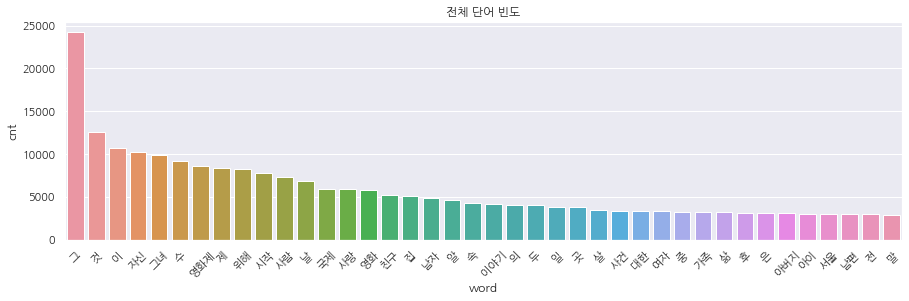

In [76]:
import matplotlib.pyplot as plt
import numpy as np; 
import seaborn as sns; 

np.random.seed(0)
plt.figure(figsize=(15,4))
# 한글 지원 폰트
sns.set(font='NanumGothic')

fig.set_facecolor('white') #fig의 배경색

c = wc.head(40)

ax = sns.barplot(x=c['word'], y= c['cnt'])
ax.set_title('전체 단어 빈도')
plt.xticks(rotation=45) #xticks는 고객 명

plt.show()

In [80]:
wc.head(50)

,word,cnt
44,그,24214
59,것,12586
9,이,10667
49,자신,10185
23,그녀,9904
3,수,9161
994,영화제,8569
982,제,8388
16,위해,8255
15,시작,7778


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cnt'>

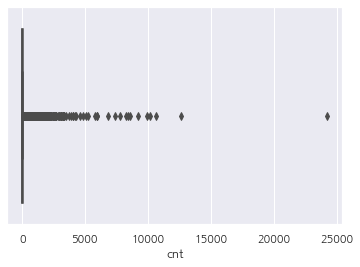

In [78]:
sns.boxplot(wc.cnt)

In [230]:
# 공통 단어 리스트 생성
common_words = set([word for word, count in word_counts.items() if count > 1000])

In [231]:
# common_words

In [232]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)


(21, 42191)


In [233]:
m = [X[i].tocoo() for i in range(X.shape[0])]
w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

In [234]:
for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)

In [236]:
new_attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) <= 15):
        word = vectorizer.get_feature_names_out()[w[i][j][0]]
        if (word in model.wv) and (word not in common_words):
            attr.append(word)
            print(word, end=', ')
        j += 1
    new_attributes.append(attr)
    print()

SF: 지구, 인류, 미래, 우주, 로봇, 박사, 우주선, 외계, 행성, 공격, 실험, 능력, 시스템, 위협, 생명체, 정부, 
가족: 아주르, 낙타, 할머니, 씨제이, 동구, 슈이트, 마갈, 미아, 펠리칸, 혼자, 벤트, 케이시, 할아버지, 엠마, 고양이, 크리스마스, 
공연: 오페라, 토스카, 실황, 올레, 카바, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 카르피, 비바, 왕자, 콘서트, 백작부인, 
공포(호러): 공포, 악령, 좀비, 저주, 살해, 의문, 일행, 시체, 악몽, 병원, 파티, 공격, 유령, 실종, 발생, 게임, 
기타: 뉴미디어, 페스티벌, 독립, 아시아나, 연출, 이미지, 부산, 상영작, 지하철, 청소년, 유럽, 부천, 노인, 의도, 판타스틱, 공간, 
다큐멘터리: 다큐, 환경, 노동자, 기록, 역사, 카메라, 과정, 지역, 투쟁, 인디다큐페스티발, 문제, 지금, 북한, 현재, 일본, 문화, 
드라마: 부문, 연출, 독립, 부산, 의도, 할머니, 경쟁, 상처, 혼자, 배우, 시절, 문제, 거리, 노인, 여인, 일본, 
멜로로맨스: 부부, 유혹, 연애, 애인, 새엄마, 불륜, 남자친구, 유부녀, 정사, 출장, 선배, 여자친구, 커플, 만난, 고백, 동거, 
뮤지컬: 뮤지컬, 에스메랄다, 충무로, 모차르트, 토스카, 니웨, 카바, 바흐, 페뷔스, 프롤, 모도, 카르피, 제루샤, 샤오캉, 데이비, 팬텀, 
미스터리: 진실, 민혁, 의문, 미스터리, 형사, 현우, 발생, 방독면, 범인, 살해, 충격, 소설, 용의자, 공포, 여인, 추적, 
범죄: 범죄, 마약, 형사, 살해, 수사, 한길수, 범인, 은행, 작전, 동료, 보스, 마피아, 용의자, 복수, 제안, 시체, 
사극: 조선, 신기전, 아가멤논, 황제, 루안, 하선, 윤서, 트로이, 세자, 허균, 노준, 채선, 신재효, 히파티아, 권력, 아킬레스, 
서부극(웨스턴): 서부, 보안관, 벌린, 카우보이, 그레이프바인, 헨리, 개릿, 무법자, 프린트, 마적, 태구, 현상금, 분노, 버질, 랜

## 4. embedding model과 단어 셋으로 WEAT score 구해보기

이제 WEAT_score를 구해봅시다.

traget_X는 art, target_Y는 gen, attribute_A는 '드라마', attribute_B는 '액션' 과 같이 정해줄 수 있습니다.

target_X 는 art, target_Y 는 gen으로 고정하고 attribute_A, attribute_B를 바꿔가면서 구해봅시다. 구한 결과를 21x21 매트릭스 형태로 표현해서 matrix 라는 변수에 담아봅시다.

In [237]:
from tqdm import trange

In [238]:
matrix = [[0 for _ in range(len(genre_name))] for _ in trange(len(genre_name))]

100%|██████████| 21/21 [00:00<00:00, 117440.51it/s]


In [239]:
len(new_attributes)

21

In [240]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in new_attributes[i]])
        B = np.array([model.wv[word] for word in new_attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

matrix를 채워보았습니다. WEAT score 값을 보고, 과연 우리의 직관과 비슷한지 살펴볼까요?

In [241]:
import pandas as pd

In [242]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 -0.8520448
SF 공연 -0.21097745
SF 공포(호러) -0.85959536
SF 기타 0.20376794
SF 다큐멘터리 0.22327955
SF 드라마 -0.1836893
SF 멜로로맨스 -0.88814753
SF 뮤지컬 0.05252678
SF 미스터리 -0.69036233
SF 범죄 -0.44814387
SF 사극 -0.199117
SF 서부극(웨스턴) -0.7178726
SF 성인물(에로) -0.7775963
SF 스릴러 -0.5816295
SF 애니메이션 -0.051432747
SF 액션 -0.5202606
SF 어드벤처 -1.0923755
SF 전쟁 0.01061272
SF 코미디 -0.5621623
SF 판타지 -0.515978
가족 공연 0.9298683
가족 공포(호러) 0.42860508
가족 기타 1.0274221
가족 다큐멘터리 0.93651825
가족 드라마 1.0063854
가족 멜로로맨스 -0.47078893
가족 뮤지컬 1.0787196
가족 미스터리 0.4458225
가족 범죄 0.6355684
가족 사극 1.0247259
가족 서부극(웨스턴) 0.8685211
가족 성인물(에로) 0.16682301
가족 스릴러 0.47441217
가족 애니메이션 0.97900873
가족 액션 0.6160354
가족 어드벤처 0.6231132
가족 전쟁 1.0021089
가족 코미디 0.7172444
가족 판타지 1.0391321
공연 공포(호러) -0.4465204
공연 기타 0.65996933
공연 다큐멘터리 0.53179663
공연 드라마 0.043504886
공연 멜로로맨스 -0.8979335
공연 뮤지컬 1.0527428
공연 미스터리 -0.3076074
공연 범죄 -0.16601554
공연 사극 0.21871437
공연 서부극(웨스턴) -0.53691846
공연 성인물(에로) -0.71729726
공연 스릴러 -0.24979842
공연 애니메이션 0.29298538
공연 액션 -0.148296
공연 어드벤처 

In [249]:
corr_df = pd.DataFrame(matrix, columns=genre_name, index=genre_name)

In [250]:
corr_df_unstack = pd.DataFrame(corr_df.unstack(), columns=['score']).sort_values(by='score')

In [251]:
corr_df_unstack.to_csv('corr_df_unstack.csv')

In [252]:
corr_df_unstack.reset_index(inplace=True)
corr_df_unstack.columns = ['A','B','score']

In [253]:
corr_df_unstack.to_csv('corr_df_unstack.csv', index=False)

## WEAT score가 0.8 이상, -0.8 이하의 경우

- 양수 점수: X(예술영화) 단어들이 A 속성 단어들과 더 많이 연관되어 있고, Y(일반영화) 단어들이 B 속성 단어들과 더 많이 연관되어 있음
- 음수 점수: X(예술영화) 단어들이 B 속성 단어들과 더 많이 연관되어 있고, Y(일반영화) 단어들이 A 속성 단어들과 더 많이 연관되어 있음
- 점수의 크기: 절대값이 클수록 편향의 정도가 큼

In [254]:
corr_df_unstack[np.abs(corr_df_unstack.score) >= 0.8]

,A,B,score
0,어드벤처,SF,-1.092376
1,서부극(웨스턴),사극,-0.987234
2,어드벤처,사극,-0.944324
3,코미디,뮤지컬,-0.934286
4,애니메이션,기타,-0.927608
5,멜로로맨스,기타,-0.918840
6,멜로로맨스,다큐멘터리,-0.918343
7,멜로로맨스,드라마,-0.914023
8,멜로로맨스,공연,-0.897933
9,멜로로맨스,SF,-0.888148


In [245]:
high_corr = corr_df_unstack[np.abs(corr_df_unstack.score) >= 0.8]

In [246]:
high_corr.reset_index(inplace=True)
high_corr.columns = ['A','B','score']

### 예술 영화와 가까운 장르

In [255]:
x1 = high_corr[high_corr.score > 0].A.tolist()
x2 = high_corr[high_corr.score < 0].B.tolist()

print(x1)
print(x2)

['사극', '범죄', '뮤지컬', '공연', '범죄', '전쟁', '드라마', '전쟁', '다큐멘터리', '전쟁', '애니메이션', '전쟁', '기타', '뮤지컬']
['SF', '전쟁', '다큐멘터리', '다큐멘터리', '기타', 'SF', '전쟁', '기타', '다큐멘터리']


### 일반영화와 가까운 장르

In [248]:
y1 = high_corr[high_corr.score < 0].A.tolist()
y2 = high_corr[high_corr.score > 0].B.tolist()

print(y1)
print(y2)

['판타지', '코미디', '멜로로맨스', '드라마', '드라마', '어드벤처', '판타지', '멜로로맨스', '성인물(에로)']
['가족', '공포(호러)', '멜로로맨스', '가족', '멜로로맨스', '어드벤처', '가족', '멜로로맨스', '가족', '서부극(웨스턴)', '가족', '가족', '가족', '가족']


### 결과 해석
- weat score에 따른 결과를 해석해보면 예술 영화와 가까운 장르는 다큐멘터리, SF, 공연, 뮤지컬이 나타났고 이는 우리의 상식에 부합한 결과가 나왔다
- 일반 영화와 가까운 장르는 판타지, 코미디, 멜로로멘스, 드라마, 가족 등 일반적인 우리의 생각과 유사한 결과가 나왔다

## STEP 4. WEAT score 계산과 시각화
---
영화 구분, 영화 장르에 따른 편향성을 측정하여 WEAT score로 계산해 보고 이를 Heatmap 형태로 시각화해 봅시다. 편향성이 두드러지는 영화장르 attribute 구성에는 어떤 케이스가 있는지 시각적으로 두드러지게 구성되면 좋습니다.

<AxesSubplot:>

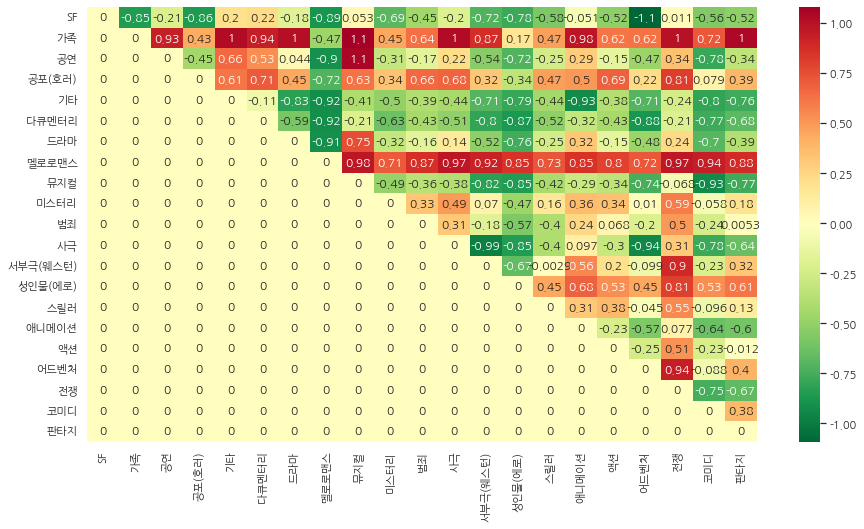

In [256]:
import matplotlib.pyplot as plt
import numpy as np; 
import seaborn as sns; 

np.random.seed(0)
plt.figure(figsize=(15,8))
# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 
plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

# 더 좋은 키워드를 뽑아 내기 위한 시도

## Bertopic
- 결과적으로 먼저 말하자면 좋은 토픽을 뽑아내지 못했다.
- 이는 시놉시스를 바탕으로 키워드를 뽑아내서 줄거리의 내용들을 바탕으로 키워드를 뽑아서 잘 안된 것 같다
- 오히려 장르별 리뷰 데이터가 있다면 더 좋은 결과가 나오지 않을까 싶다 

In [54]:
# !pip install transformers
# !pip install bertopic

In [3]:
from transformers import AutoTokenizer, AutoModel
from bertopic import BERTopic
import torch

In [7]:
def get_bertopic_keywords(data):
    num_topics = 2

    topic_model = BERTopic(language='korean', nr_topics=num_topics)
    topics, _ = topic_model.fit_transform(data)

    #topic_info = topic_model.get_topic_info()
    representative_keywords = topic_model.get_topic(0)

    return representative_keywords

### 위에서 저장해둔 processed_text 불러오기

In [10]:
processed_texts = []

for txt in tqdm(genre_txt):
    li = []
    with open("nouns_" + txt, "r") as file:
        for fi in file:
            ll = [ name.strip() for name in fi.split(",")]
            li.append(ll)
    processed_texts.append(li)

100%|██████████| 21/21 [00:00<00:00, 27.30it/s]


In [11]:
len(processed_texts)

21

In [12]:
keywords = {}

for i in trange(len(processed_texts)):
    data = [' '.join(texts) for texts in processed_texts[i]]
    representative_keywords = get_bertopic_keywords(data)
    keywords[genre_name[i]] = representative_keywords
    print(f'{genre_name[i]} : ', representative_keywords)

  5%|▍         | 1/21 [00:43<14:34, 43.73s/it]

SF :  [('시작', 0.04312727739196724), ('자신', 0.04175636960295028), ('위해', 0.04164523443617196), ('지구', 0.04081382963404651), ('인간', 0.034671911135255994), ('그녀', 0.03153419593600329), ('로봇', 0.031019257660393672), ('사람', 0.029052822231230818), ('인류', 0.028714421051607073), ('미래', 0.02414166597302243)]


 10%|▉         | 2/21 [00:56<08:09, 25.79s/it]

가족 :  [('크리스마스', 0.46510137388392647), ('산타클로스', 0.2100265369182358), ('순록', 0.13601941969118572), ('썰매', 0.13601941969118572), ('토마스', 0.12601592215094148), ('마을', 0.1152753817315867), ('아기', 0.11245649297481514), ('엄마', 0.09920778069324644), ('도울', 0.09597557817757807), ('케이드', 0.09597557817757807)]


 14%|█▍        | 3/21 [01:11<06:08, 20.49s/it]

공연 :  [('이집트', 0.3232700405339472), ('에티오피아', 0.31034391066896977), ('라다', 0.26236788661896265), ('메스', 0.26236788661896265), ('공주', 0.23616661052251148), ('아이', 0.20292581722577976), ('리스', 0.1724132837049832), ('사랑', 0.14183144253026073), ('임명', 0.1406945523785784), ('총독', 0.1354589937857294)]


 19%|█▉        | 4/21 [02:30<12:25, 43.83s/it]

공포(호러) :  [('여름', 3.759484538389698), ('걱정', 3.759484538389698), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05)]


 24%|██▍       | 5/21 [03:28<13:00, 48.78s/it]

기타 :  [('영화제', 0.08669186898251016), ('국제', 0.07336311517065601), ('서울', 0.06207621322486799), ('단편', 0.0540694118979405), ('자신', 0.03545001601499422), ('영화', 0.03442919547871819), ('사람', 0.03371403907664201), ('이야기', 0.030738301669469177), ('그녀', 0.030251643779865677), ('남자', 0.026952288016357285)]


 29%|██▊       | 6/21 [06:02<21:10, 84.69s/it]

다큐멘터리 :  [('영화제', 0.05037811084085037), ('영화', 0.04330751247268115), ('국제', 0.035590975298124335), ('사람', 0.0352210267454699), ('다큐멘터리', 0.03369001217157633), ('대한', 0.03125924880679807), ('이야기', 0.029622507529112743), ('여성', 0.028565288951803783), ('자신', 0.02702353640365247), ('그녀', 0.026770896665906617)]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

드라마 :  [('그녀', 0.043185713034779936), ('영화제', 0.04214913565816061), ('자신', 0.0388650375603075), ('사람', 0.03388115270058164), ('영화', 0.033307805558884594), ('시작', 0.03034125978182153), ('사랑', 0.029500635690965327), ('위해', 0.028134272036537542), ('국제', 0.02411326468711116), ('친구', 0.024023790078104807)]


 38%|███▊      | 8/21 [14:12<34:23, 158.75s/it]

멜로로맨스 :  [('그녀', 0.07168532839632231), ('사랑', 0.0527236478815652), ('자신', 0.04529221726559537), ('시작', 0.03971522125680573), ('남자', 0.038407627057848906), ('남편', 0.03803051039777592), ('사람', 0.03277272411673213), ('여자', 0.032559152138826174), ('친구', 0.030532053668948837), ('위해', 0.029659628866303786)]


 43%|████▎     | 9/21 [14:21<22:22, 111.89s/it]

뮤지컬 :  [('영화', 0.05046912625675971), ('음악', 0.04948933940514191), ('그녀', 0.04774143678687375), ('뮤지컬', 0.04644745967207805), ('영화제', 0.037973722659931215), ('모차르트', 0.034158730053145576), ('자신', 0.031875237635848236), ('최고', 0.03005152479005119), ('사랑', 0.029189723574844704), ('세계', 0.02901608214364618)]


 48%|████▊     | 10/21 [14:43<15:25, 84.16s/it]

미스터리 :  [('지인', 0.7925760456773437), ('주일', 0.7925760456773437), ('정상', 0.7925760456773437), ('의도', 0.7925760456773437), ('진부령', 0.7925760456773437), ('목요일', 0.7925760456773437), ('금요일', 0.7295775334146661), ('연출', 0.6927319343982584), ('여름', 0.6665938816475159), ('변화', 0.6297631358394987)]


 52%|█████▏    | 11/21 [15:22<11:42, 70.27s/it]

범죄 :  [('사건', 0.04528037978231955), ('위해', 0.0400832225384571), ('자신', 0.03982837680945856), ('시작', 0.036182514945322326), ('경찰', 0.035246917315854644), ('그녀', 0.02954555311582451), ('살인', 0.02493977967068716), ('사람', 0.02463234969346793), ('조직', 0.024478125562454572), ('범죄', 0.022281592827690027)]


 57%|█████▋    | 12/21 [15:31<07:46, 51.82s/it]

사극 :  [('조선', 0.07009275329200143), ('위해', 0.04940866485637453), ('시작', 0.04125262315855463), ('황제', 0.0411458579323243), ('권력', 0.03165065994794177), ('역사', 0.03085260689415177), ('최고', 0.03082608670038486), ('사람', 0.027743478030346373), ('이야기', 0.027424539461468243), ('자신', 0.02543446262661763)]


 62%|██████▏   | 13/21 [15:37<05:03, 37.95s/it]

서부극(웨스턴) :  False


 67%|██████▋   | 14/21 [16:27<04:50, 41.50s/it]

성인물(에로) :  [('그녀', 0.09745553790161196), ('남편', 0.060351927468316025), ('영화', 0.05357694680773182), ('마사지', 0.04942686745144671), ('자신', 0.04718358281945421), ('관계', 0.04343845452885209), ('섹스', 0.040132247490179365), ('그린', 0.03763007667191447), ('남자', 0.03398707824106282), ('시작', 0.03270195814103651)]


 71%|███████▏  | 15/21 [17:27<04:41, 46.92s/it]

스릴러 :  [('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05)]


 76%|███████▌  | 16/21 [19:32<05:52, 70.57s/it]

애니메이션 :  [('애니메이션', 0.07153022116059672), ('국제', 0.06527823252073633), ('영화제', 0.05947147386565797), ('친구', 0.038515205511523945), ('시작', 0.0313321287497541), ('서울', 0.030807880261206608), ('페스티벌', 0.03067787349627129), ('위해', 0.030652761549035606), ('자신', 0.02869431041640794), ('사람', 0.026679262269461327)]


 81%|████████  | 17/21 [21:28<05:37, 84.33s/it]

액션 :  [('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05)]


 86%|████████▌ | 18/21 [21:44<03:10, 63.55s/it]

어드벤처 :  [('위해', 0.04483122169598428), ('영화', 0.03748670117393842), ('친구', 0.03018916082489911), ('이야기', 0.029114964330165846), ('여행', 0.026274727065815354), ('시작', 0.02581610574984412), ('영화제', 0.02533361834300761), ('세계', 0.02466051862147685), ('가족', 0.023659968202512364), ('자신', 0.023287872523982043)]


 90%|█████████ | 19/21 [21:58<01:37, 48.73s/it]

전쟁 :  [('전쟁', 0.04897636299566816), ('전투', 0.03975586993570974), ('위해', 0.0386222572291251), ('시작', 0.03683075585437569), ('독일군', 0.03397774253272141), ('작전', 0.031385062153210075), ('부대', 0.030721078540134047), ('독일', 0.029280641276060972), ('사람', 0.02336057414690756), ('자신', 0.022460069545604807)]


 95%|█████████▌| 20/21 [23:58<01:10, 70.09s/it]

코미디 :  [('시작', 0.03367888865369271), ('그녀', 0.03294234722037161), ('위해', 0.03231899372612305), ('영화', 0.032284792806113106), ('자신', 0.03141498941636332), ('사람', 0.027237605379587877), ('친구', 0.025450752761161412), ('영화제', 0.024356542610868705), ('가족', 0.0227252054336242), ('사랑', 0.022548615134917526)]


100%|██████████| 21/21 [24:16<00:00, 69.34s/it]

판타지 :  [('컬러', 2.106871819582936), ('골목', 1.933639711088689), ('겨울', 1.8323281087474863), ('가장', 1.399442037635239), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05)]


In [15]:
keywords[genre_name[1]]

[('크리스마스', 0.46510137388392647),
 ('산타클로스', 0.2100265369182358),
 ('순록', 0.13601941969118572),
 ('썰매', 0.13601941969118572),
 ('토마스', 0.12601592215094148),
 ('마을', 0.1152753817315867),
 ('아기', 0.11245649297481514),
 ('엄마', 0.09920778069324644),
 ('도울', 0.09597557817757807),
 ('케이드', 0.09597557817757807)]

- 좋은 키워드가 잘 뽑히지 않고 시간도 너무 오래걸려서 사용하지 않기로 결정했다

## krwordrank

In [89]:
# krwordrank 설치

!pip install krwordrank

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [22]:
# library import

import pandas as pd
import numpy as np
from krwordrank.word import KRWordRank
from krwordrank.word import summarize_with_keywords
from krwordrank.sentence import summarize_with_sentences
import pickle

In [23]:
def get_krwordrank(texts, min_count, max_length, beta, maxiter):

    a = [' '.join(text) for text in texts]
    
    # Keyword 알고리즘에 데이터 적용
    keywords = summarize_with_keywords(a, min_count=min_count, max_length=max_length, beta=beta, max_iter=maxiter, verbose=True)
    
    # 키워드 뽑아내기.
    for word, r in sorted(keywords.items(), key=lambda x:x[1], reverse=True)[:30]:
       print(word, end=', ')
        
    return keywords

In [25]:
# 하이퍼파라미터
min_count=2 
max_length=100
beta=0.85
max_iter=15

# keywords = get_krwordrank(processed_texts[0], min_count, max_length, beta, max_iter)

In [34]:
kr_keywords = {}

for i in range(len(processed_texts)):
    keywords = get_krwordrank(processed_texts[i], min_count, max_length, beta, max_iter)
    kr_keywords[genre_name[i]] = keywords

scan vocabs ... 
num vocabs = 4884
done = 9 Early stopped.
자신, 위해, 시작, 지구, 우주, 사람, 인간, 인류, 그녀, 미래, 세계, 외계, 박사, 로봇, 영화, 비밀, 발견, 존재, 아이, 공격, 모든, 친구, 세상, 한편, 기억, 과학, 사건, 전쟁, 능력, 아버지, scan vocabs ... 
num vocabs = 2294
done = 10 Early stopped.
영화제, 엄마, 자신, 가족, 위해, 아빠, 국제, 친구, 시작, 아버지, 그녀, 아들, 마을, 사람, 학교, 아이, 할머니, 사랑, 소년, 대한, 이야기, 가장, 세상, 단편, 모두, 사이, 마음, 소녀, 아내, 이자, scan vocabs ... 
num vocabs = 2478
done = 10 Early stopped.
사랑, 오페라, 자신, 그녀, 공연, 위해, 실황, 음악, 백작, 결혼, 토스카, 콘서트, 시작, 공주, 무대, 도시, 왕자, 친구, 사이, 카바, 세계, 악마, 아내, 비극, 공작, 연인, 여인, 모습, 영화, 아이, scan vocabs ... 
num vocabs = 8249
done = 9 Early stopped.
시작, 위해, 친구, 사람, 그녀, 자신, 영화, 사건, 공포, 남자, 발견, 죽음, 마을, 살인, 가족, 여자, 아이, 소녀, 좀비, 비밀, 이야기, 대한, 명의, 사이, 살해, 하나, 사고, 정체, 국제, 점점, scan vocabs ... 
num vocabs = 7902
done = 11 Early stopped.
영화제, 국제, 단편, 자신, 서울, 이야, 사람, 남자, 그녀, 위해, 페스티벌, 대한, 시작, 사랑, 여자, 친구, 통해, 독립, 뉴미디어, 아이, 작품, 소녀, 다른, 시간, 엄마, 우리, 모습, 연출, 이미지, 감독, scan vocabs ... 
num vocabs = 17804
done = 9 Early stopped.
영화, 다큐, 국제, 대한, 사람, 감독, 이야기

In [35]:
genre_keywords = {}

for k in kr_keywords.keys():
    print(k)
    words = []
    for word, r in sorted(kr_keywords[k].items(), key=lambda x:x[1], reverse=True)[:30]:
        words.append(word)
    print(words)
    print()
    genre_keywords[k] = words

SF
['자신', '위해', '시작', '지구', '우주', '사람', '인간', '인류', '그녀', '미래', '세계', '외계', '박사', '로봇', '영화', '비밀', '발견', '존재', '아이', '공격', '모든', '친구', '세상', '한편', '기억', '과학', '사건', '전쟁', '능력', '아버지']

가족
['영화제', '엄마', '자신', '가족', '위해', '아빠', '국제', '친구', '시작', '아버지', '그녀', '아들', '마을', '사람', '학교', '아이', '할머니', '사랑', '소년', '대한', '이야기', '가장', '세상', '단편', '모두', '사이', '마음', '소녀', '아내', '이자']

공연
['사랑', '오페라', '자신', '그녀', '공연', '위해', '실황', '음악', '백작', '결혼', '토스카', '콘서트', '시작', '공주', '무대', '도시', '왕자', '친구', '사이', '카바', '세계', '악마', '아내', '비극', '공작', '연인', '여인', '모습', '영화', '아이']

공포(호러)
['시작', '위해', '친구', '사람', '그녀', '자신', '영화', '사건', '공포', '남자', '발견', '죽음', '마을', '살인', '가족', '여자', '아이', '소녀', '좀비', '비밀', '이야기', '대한', '명의', '사이', '살해', '하나', '사고', '정체', '국제', '점점']

기타
['영화제', '국제', '단편', '자신', '서울', '이야', '사람', '남자', '그녀', '위해', '페스티벌', '대한', '시작', '사랑', '여자', '친구', '통해', '독립', '뉴미디어', '아이', '작품', '소녀', '다른', '시간', '엄마', '우리', '모습', '연출', '이미지', '감독']

다큐멘터리
['영화', '다큐', '국제', '대한', '사람', '감독', '이야기', '위해', 

- 위의 방식으로 단순하게 키워드를 뽑아내니 겹치는 단어들이 자주 등장하였다
- 전체 데이터셋에서 키워드를 뽑아내서 상위 키워드를 common_keywords에 넣어둔뒤 이를 불용어 처리하여 키워드에서 제거해 줄 것이다

### 모든 장르의 데이터를 합친 뒤 키워드 추출

In [27]:
all_texts = [text for texts in processed_texts for text in texts]
all_keywords = get_krwordrank(all_texts, min_count, max_length, beta, max_iter)

scan vocabs ... 
num vocabs = 52791
done = 8 Early stopped.
영화, 자신, 그녀, 위해, 시작, 국제, 사람, 사랑, 남자, 친구, 이야, 대한, 여자, 아이, 가족, 아버, 마을, 사건, 남편, 감독, 단편, 사이, 아들, 세계, 엄마, 마음, 통해, 시간, 애니메이션, 다시, 

In [30]:
common_keywords = []

for word, r in sorted(all_keywords.items(), key=lambda x:x[1], reverse=True)[:50]:
    common_keywords.append(word)
    print(word, r)

영화 148.49027402464256
자신 106.76887786241456
그녀 101.90635674337334
위해 94.6001083440194
시작 86.12531945032528
국제 85.14697987794528
사람 66.2874036665378
사랑 59.69600267778325
남자 58.902978278249954
친구 56.52198865207719
이야 43.95604331252879
대한 43.154244587400534
여자 41.834930626088365
아이 41.481690495970426
가족 34.78957740740764
아버 34.246361312669315
마을 33.81944582124164
사건 33.514770060269086
남편 31.63113110470899
감독 31.031907367895197
단편 30.952593255723585
사이 29.198183647139402
아들 28.613183495172635
세계 28.15990761906119
엄마 27.87803965317183
마음 26.94088895654218
통해 26.858572109094432
시간 25.39721254885324
애니메이션 25.335951991478005
다시 25.222895657462665
소녀 24.217824447365622
서울 24.11919801958648
다른 24.04264489802512
모습 23.58365670453804
아내 23.271033179962178
발견 23.006505452484625
서로 22.756569762404823
세상 22.700521837914618
이자 22.679755977801996
작품 22.00240622947726
여성 21.694273916202985
미국 21.535929045975127
결혼 20.81999095961733
생각 20.548335935694457
하나 20.429425880761467
때문 20.27835382132224
관계 20.1

In [31]:
' '.join(common_keywords)

'영화 자신 그녀 위해 시작 국제 사람 사랑 남자 친구 이야 대한 여자 아이 가족 아버 마을 사건 남편 감독 단편 사이 아들 세계 엄마 마음 통해 시간 애니메이션 다시 소녀 서울 다른 모습 아내 발견 서로 세상 이자 작품 여성 미국 결혼 생각 하나 때문 관계 한편 다큐 가장'

In [32]:
common_keywords.extend(['충무','몰래','한편','이자','사실','어머','만난'])

- 추가적으로 직관에 맞지않는 단어들을 제거해 주었다

In [39]:
genre_keywords_stopwords = {}

for k in kr_keywords.keys():
    print(k)
    words = []
    for word, r in sorted(kr_keywords[k].items(), key=lambda x:x[1], reverse=True):
        if word not in common_keywords:
            words.append(word)
    print(words[:30])
    print()
    genre_keywords[k] = words[:30]

SF
['지구', '우주', '인간', '인류', '미래', '외계', '박사', '로봇', '비밀', '존재', '공격', '모든', '기억', '과학', '전쟁', '능력', '아버지', '프로', '정체', '연구', '죽음', '정부', '개발', '발생', '사고', '행성', '실험', '슈퍼', '데이', '과거']

가족
['영화제', '아빠', '아버지', '학교', '할머니', '소년', '이야기', '모두', '미아', '아주', '시골', '크리', '모험', '인간', '동구', '소식', '할아버지', '어린이', '혼자', '인도', '결심', '엠마', '인형', '주인', '모든', '장난감', '부모', '마리', '주니', '과연']

공연
['오페라', '공연', '실황', '음악', '백작', '토스카', '콘서트', '공주', '무대', '도시', '왕자', '카바', '악마', '비극', '공작', '연인', '여인', '지휘', '발레', '프로', '기사', '오텔로', '이야기', '이탈리아', '카르', '그린', '총독', '파리', '여왕', '극장']

공포(호러)
['공포', '죽음', '살인', '좀비', '비밀', '이야기', '명의', '살해', '사고', '정체', '점점', '여행', '저주', '이후', '정신', '파티', '의문', '병원', '일행', '악령', '도시', '공격', '크리', '게임', '발생', '모두', '레이', '저택', '데이', '실종']

기타
['영화제', '페스티벌', '독립', '뉴미디어', '우리', '연출', '이미지', '상영작', '아버지', '도시', '소년', '청소년', '아시아', '사회', '주인', '기억', '지하철', '현실', '여행', '촬영', '판타스틱', '한국', '모든', '공간', '영상', '그린', '수상', '프로', '하루', '간다']

다큐멘터리
['이야기', '우리', '한국', '환경', '사회', '음악

In [40]:
genre_keywords

{'SF': ['지구',
  '우주',
  '인간',
  '인류',
  '미래',
  '외계',
  '박사',
  '로봇',
  '비밀',
  '존재',
  '공격',
  '모든',
  '기억',
  '과학',
  '전쟁',
  '능력',
  '아버지',
  '프로',
  '정체',
  '연구',
  '죽음',
  '정부',
  '개발',
  '발생',
  '사고',
  '행성',
  '실험',
  '슈퍼',
  '데이',
  '과거'],
 '가족': ['영화제',
  '아빠',
  '아버지',
  '학교',
  '할머니',
  '소년',
  '이야기',
  '모두',
  '미아',
  '아주',
  '시골',
  '크리',
  '모험',
  '인간',
  '동구',
  '소식',
  '할아버지',
  '어린이',
  '혼자',
  '인도',
  '결심',
  '엠마',
  '인형',
  '주인',
  '모든',
  '장난감',
  '부모',
  '마리',
  '주니',
  '과연'],
 '공연': ['오페라',
  '공연',
  '실황',
  '음악',
  '백작',
  '토스카',
  '콘서트',
  '공주',
  '무대',
  '도시',
  '왕자',
  '카바',
  '악마',
  '비극',
  '공작',
  '연인',
  '여인',
  '지휘',
  '발레',
  '프로',
  '기사',
  '오텔로',
  '이야기',
  '이탈리아',
  '카르',
  '그린',
  '총독',
  '파리',
  '여왕',
  '극장'],
 '공포(호러)': ['공포',
  '죽음',
  '살인',
  '좀비',
  '비밀',
  '이야기',
  '명의',
  '살해',
  '사고',
  '정체',
  '점점',
  '여행',
  '저주',
  '이후',
  '정신',
  '파티',
  '의문',
  '병원',
  '일행',
  '악령',
  '도시',
  '공격',
  '크리',
  '게임',
  '발생',
  '모두',
  '레이',
  '저택',
  '데이',


In [41]:
pd.DataFrame(genre_keywords).T.to_csv('kr_keywords.csv')

## weat score 다시 측정

target_art = ['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']
     
     
target_gen = ['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']

- 예술 영화를 대표하는 단어와 일반영화를 대표하는 단어 자체도 이미 장르에 편향이 되어있는 것으로 보아 다시 키워드 추출부터 하고자 한다

### 예술영화와 일반영화 키워드 추출

In [17]:
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

art_gen_txt = [art_txt, gen_txt]
art_gen_txt 

['synopsis_art.txt', 'synopsis_gen.txt']

In [272]:
texts = read_files(art_gen_txt)

100%|██████████| 2/2 [00:00<00:00, 28.74it/s]


In [274]:
# art_gen_texts = preprocess_texts_korean(texts)

In [275]:
len(art_gen_texts)

2

In [175]:
for idx in trange(len(art_gen_txt)):
    file_name = "nouns_"+art_gen_txt[idx]

    with open(file_name, 'w+') as file:
        for num, i in enumerate(art_gen_texts[idx]):
            if num+1 < len(art_gen_texts[idx]):
                file.write(', '.join(i) + "\n")
            else:
                file.write(', '.join(i))

100%|██████████| 2/2 [00:00<00:00, 12.49it/s]


## 데이터셋 다시 불러오기

In [18]:
art_gen_texts = []

for txt in tqdm(art_gen_txt):
    li = []
    with open("nouns_" + txt, "r") as file:
        for fi in file:
            ll = [ name.strip() for name in fi.split(",")]
            li.append(ll)
    art_gen_texts.append(li)

100%|██████████| 2/2 [00:00<00:00,  3.56it/s]


In [19]:
len(art_gen_texts)

2

In [42]:
art_gen_keywords = {}
name = ['art','gen']

for i in range(len(art_gen_texts)):
    keywords = get_krwordrank(art_gen_texts[i], min_count, max_length, beta, max_iter)
    print(name[i])
    words = []
    for word, r in sorted(keywords.items(), key=lambda x:x[1], reverse=True):
        if word not in common_keywords:
            words.append(word)
    print(words[:30])
    print()
    art_gen_keywords[name[i]] = words

scan vocabs ... 
num vocabs = 21381
done = 8 Early stopped.
시작, 그녀, 자신, 위해, 영화, 사랑, 사람, 친구, 남자, 아이, 마을, 가족, 이야기, 여자, 대한, 아버, 감독, 사건, 마음, 엄마, 사이, 아들, 세상, 소녀, 서로, 시간, 세계, 아내, 다시, 이자, art
['이야기', '여행', '음악', '모든', '과연', '생활', '최고', '비밀', '점점', '경찰', '도시', '마지막', '하루', '모두', '학교', '순간', '인생', '소년', '우리', '아빠', '기억', '명의', '죽음', '사고', '간다', '일상', '전쟁', '살인', '프랑', '이제']

scan vocabs ... 
num vocabs = 46739
done = 8 Early stopped.
영화, 자신, 그녀, 국제, 위해, 시작, 사람, 남자, 친구, 사랑, 이야, 대한, 여자, 아이, 단편, 아버, 남편, 사건, 가족, 마을, 감독, 통해, 애니메이션, 사이, 세계, 아들, 서울, 엄마, 작품, 마음, gen
['주인', '우리', '인간', '생활', '모든', '도시', '경찰', '죽음', '여행', '비밀', '소년', '모두', '명의', '일본', '학교', '페스티벌', '최고', '간다', '상황', '한국', '점점', '대학', '사회', '전쟁', '독립', '기억', '마지', '이제', '살인', '순간']



### 겹치는 단어들을 제거하고 상위 15개 단어를 선정했다

In [43]:
art_gen_list = list(art_gen_keywords.values())

In [44]:
art = art_gen_list[0]
gen = art_gen_list[1]

art = [x for x in art if x not in gen[:30]]
gen = [x for x in gen if x not in art[:30]]

target_art = art[:15]
target_gen = gen[:15]

In [45]:
print('예술 영화의 주요 키워드 :', ' '.join(target_art))
print('일반 영화의 주요 키워드 :', ' '.join(target_gen))

예술 영화의 주요 키워드 : 이야기 음악 과연 마지막 하루 인생 아빠 사고 일상 프랑 지금 위기 그린 과거 준비
일반 영화의 주요 키워드 : 주인 우리 인간 생활 모든 도시 경찰 죽음 여행 비밀 소년 모두 명의 일본 학교


### weat score 다시 계산하기

In [46]:
matrix = [[0 for _ in range(len(genre_name))] for _ in trange(len(genre_name))]

100%|██████████| 21/21 [00:00<00:00, 142524.89it/s]


In [47]:
attrs = list(genre_keywords.values())

In [48]:
len(attrs)

21

In [50]:
from gensim.models import KeyedVectors

In [51]:
model = KeyedVectors.load_word2vec_format("./w2v")
print("모델  load 완료!")

모델  load 완료!


In [57]:
X = np.array([model[word] for word in target_art])
Y = np.array([model[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model[word] for word in attrs[i] if word in model])
        B = np.array([model[word] for word in attrs[j] if word in model])
        matrix[i][j] = weat_score(X, Y, A, B)

matrix를 채워보았습니다. WEAT score 값을 보고, 과연 우리의 직관과 비슷한지 살펴볼까요?

In [58]:
import pandas as pd

In [59]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 -0.26503843
SF 공연 -0.38849068
SF 공포(호러) -0.04692788
SF 기타 -0.2332933
SF 다큐멘터리 -0.19575001
SF 드라마 -0.3877911
SF 멜로로맨스 -0.5724153
SF 뮤지컬 -0.31485236
SF 미스터리 -0.35105324
SF 범죄 -0.023438456
SF 사극 -0.3403825
SF 서부극(웨스턴) -0.32503083
SF 성인물(에로) -0.4789084
SF 스릴러 -0.22499694
SF 애니메이션 -0.18958488
SF 액션 0.09928217
SF 어드벤처 -0.049484417
SF 전쟁 0.26209944
SF 코미디 -0.45158887
SF 판타지 -0.43609998
가족 공연 -0.19809444
가족 공포(호러) 0.31033278
가족 기타 0.038188223
가족 다큐멘터리 0.109631814
가족 드라마 -0.23281649
가족 멜로로맨스 -0.8183264
가족 뮤지컬 -0.09288282
가족 미스터리 0.09114297
가족 범죄 0.19851124
가족 사극 0.11024007
가족 서부극(웨스턴) 0.022631455
가족 성인물(에로) -0.56490123
가족 스릴러 0.14432229
가족 애니메이션 0.23153353
가족 액션 0.27188647
가족 어드벤처 0.38981003
가족 전쟁 0.41572878
가족 코미디 -0.26582107
가족 판타지 0.06931309
공연 공포(호러) 0.36653328
공연 기타 0.47486526
공연 다큐멘터리 0.43036285
공연 드라마 0.06489913
공연 멜로로맨스 -0.31389987
공연 뮤지컬 0.23312356
공연 미스터리 0.20212604
공연 범죄 0.26959985
공연 사극 0.40682077
공연 서부극(웨스턴) 0.17727508
공연 성인물(에로) -0.2113549
공연 스릴러 0.23507725
공연 애니메이션 0.547921

In [60]:
corr_df = pd.DataFrame(matrix, columns=genre_name, index=genre_name)

In [66]:
corr_df_unstack = pd.DataFrame(corr_df.unstack(), columns=['score']).sort_values(by='score')

In [67]:
corr_df_unstack.reset_index(inplace=True)
corr_df_unstack.columns = ['A','B','score']

In [68]:
corr_df_unstack.to_csv('new_corr_df_unstack.csv', index=False)

In [69]:
corr_df_unstack[np.abs(corr_df_unstack.score) >= 0.6]

,A,B,score
0,멜로로맨스,가족,-0.818326
1,판타지,어드벤처,-0.800901
2,코미디,전쟁,-0.731644
3,멜로로맨스,공포(호러),-0.705675
4,성인물(에로),공포(호러),-0.624210
5,코미디,어드벤처,-0.613934
6,코미디,공포(호러),-0.605255
436,전쟁,성인물(에로),0.619662
437,애니메이션,멜로로맨스,0.639808
438,전쟁,멜로로맨스,0.698961


In [78]:
high_corr = corr_df_unstack[np.abs(corr_df_unstack.score) >= 0.7]

In [79]:
high_corr

,A,B,score
0,멜로로맨스,가족,-0.818326
1,판타지,어드벤처,-0.800901
2,코미디,전쟁,-0.731644
3,멜로로맨스,공포(호러),-0.705675
439,어드벤처,멜로로맨스,0.730234
440,서부극(웨스턴),멜로로맨스,0.763457


### 예술 영화와 가까운 장르

In [80]:
x1 = high_corr[high_corr.score > 0].A.tolist()
x2 = high_corr[high_corr.score < 0].B.tolist()

print(x1)
print(x2)

['어드벤처', '서부극(웨스턴)']
['가족', '어드벤처', '전쟁', '공포(호러)']


### 일반영화와 가까운 장르

In [81]:
y1 = high_corr[high_corr.score < 0].A.tolist()
y2 = high_corr[high_corr.score > 0].B.tolist()

print(y1)
print(y2)

['멜로로맨스', '판타지', '코미디', '멜로로맨스']
['멜로로맨스', '멜로로맨스']


- 예술 영화에 대한 키워드가 아쉬웠는지 직관과 유사한 결과가 나오지 않아서 아쉽다

## STEP 4. WEAT score 계산과 시각화
---
영화 구분, 영화 장르에 따른 편향성을 측정하여 WEAT score로 계산해 보고 이를 Heatmap 형태로 시각화해 봅시다. 편향성이 두드러지는 영화장르 attribute 구성에는 어떤 케이스가 있는지 시각적으로 두드러지게 구성되면 좋습니다.

<AxesSubplot:>

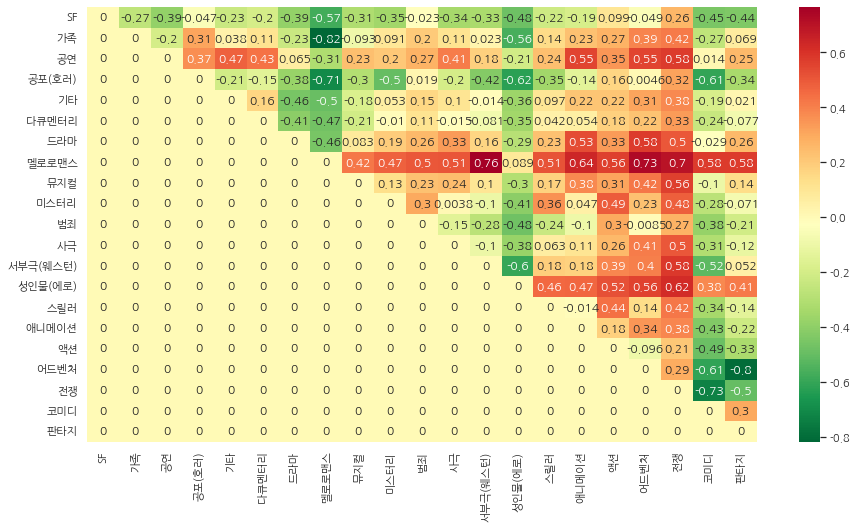

In [82]:
import matplotlib.pyplot as plt
import numpy as np; 
import seaborn as sns; 

np.random.seed(0)
plt.figure(figsize=(15,8))
# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 
plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

## KeyBert

In [98]:
# !pip install keybert

In [97]:
from keybert import KeyBERT

doc = texts[0]
# kw_model = KeyBERT()
# keywords = kw_model.extract_keywords(doc)

In [91]:
' '.join(common_keywords)

'영화 자신 그녀 위해 시작 국제 사람 사랑 남자 친구 이야 대한 여자 아이 가족 아버 마을 사건 남편 감독 단편 사이 아들 세계 엄마 마음 통해 시간 애니메이션 다시 소녀 서울 다른 모습 아내 발견 서로 세상 이자 작품 여성 미국 결혼 생각 하나 때문 관계 한편 다큐 가장 충무 몰래 한편 이자 사실 어머 만난'

In [93]:
from keybert import KeyBERT
from transformers import BertModel

In [94]:
model = BertModel.from_pretrained('skt/kobert-base-v1')
kw_model = KeyBERT(model)

config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/369M [00:00<?, ?B/s]

In [112]:
input_texts = [[' '.join(text) for text in texts] for texts in processed_texts]

In [113]:
len(input_texts)

21

In [115]:
doc = ' '.join(input_texts[0])

In [120]:
genre_name[0]

'SF'

In [121]:
keybert_kw = {}

for i in trange(len(input_texts)):
    kw = kw_model.extract_keywords(' '.join(input_texts[i]), keyphrase_ngram_range=(1, 1), top_n=20)
    keybert_kw[genre_name[i]] = kw
    
    print(genre_name[i])
    for k, _ in kw:
        print(k, end=' ')
        
    print()

  5%|▍         | 1/21 [00:15<05:02, 15.13s/it]

SF
사이버링크 비밀요원 현지 정보기관 관리인 분석관 보안관 민간조사원 에이전트 여행사 안전지대 소방관 수뇌부 상담전문가 조종사 통해 재택근무 대한 조력자 조사원 


 10%|▉         | 2/21 [00:23<03:31, 11.14s/it]

가족
막내아들 친아빠 소꿉놀이 아빠 오빠 아가 한혜숙 아들 신안군 게으름뱅이 마음씨 세상 려고 신의 가라테 스쿠버다이빙 멋대로 모범생 아기 히치하이킹 


 14%|█▍        | 3/21 [00:31<02:57,  9.83s/it]

공연
프랑켄슈타인 사티아그라하 루빈스타인 요하네스 음유시인 굴리엘모 미장센 보데몽 신랑 반려자 슈타츠카펠레 여배우 맞닥뜨 프리마돈나 맞닥뜨려 누레예프 연출가 돈키호테 베르사이유 디카프리오 


 19%|█▉        | 4/21 [00:56<04:29, 15.85s/it]

공포(호러)
학생회장 시킴 준혁 야마시타 후지사키 이동욱 김보경 유키에 요시히코 슈우카 도우미 유키오 사이보그 게시 홈페이지 웨이브 무라사키 다카하시 김규리 사이버 


 24%|██▍       | 5/21 [01:23<05:16, 19.76s/it]

기타
자녀 어린이 외동딸 막내딸 노처녀 아동 어린시절 기러기아빠 여자교도소 유부녀 손녀 미혼모 처녀귀신 자식 방탄소년단 사기꾼 영화평론가 직딩녀 선실 자손 


 29%|██▊       | 6/21 [02:17<07:50, 31.38s/it]

다큐멘터리
서울시공무원 김명준 김시스터즈 김경만 김영진 김중만 김병수 김태원 김형석 가와사키시 김경석 김영식 김영삼 김승우 김동원 김진숙 김재창 김철민 북진통일 조현준 


 33%|███▎      | 7/21 [03:39<11:12, 48.03s/it]

드라마
미혼녀 혼인신고 미혼모 짝사랑 전여자친구 여현수 부부인 러브스토리 약혼자 여중생 방송출연 라디오헤드 부인과 미성년 낭만 애정만세 연애소설 미혼 연인 비밀결사 


 38%|███▊      | 8/21 [04:14<09:30, 43.90s/it]

멜로로맨스
관광버스 투어 관광 버스정류장 버스 고속버스 여행사 관광가이드 여행자 버스킹 여행객 대중교통 여행가이드 탑승객 여행 승객 여름방학 배낭여행 모험 탑승권 


 43%|████▎     | 9/21 [04:19<06:21, 31.76s/it]

뮤지컬
미켈란젤로 영화로 음유시인 헤이월스극장 작곡가 로콩테 제멋대로 주로 프리마돈나 살리에리 뮤지컬영화 줄리엔 루디로 세바스찬 에스메랄다 서영은 라이프치히 음악가 날로 여배우 


 48%|████▊     | 10/21 [04:33<04:48, 26.25s/it]

미스터리
뮤직비디오 영화촬영장 보안관 소개 관리인 혹시 과연 컴퍼니 부팀 연락처 문의 촬영상 촬영 영화사 참석 통해 아비게일 선생님 영화배우 찍기 


 52%|█████▏    | 11/21 [04:53<04:02, 24.24s/it]

범죄
헤갈후젠 여배우 맞닥뜨리 필연 보디가드 나현정 실오라기 아말도 안유 일념 생으로 차례대로 주로 반드시 권해효 진척 안현민 소꿉친구 부인과 미육군 


 57%|█████▋    | 12/21 [04:58<02:44, 18.25s/it]

사극
황족 춘추전국시대 대왕대비 황실 정순왕후 명나라 정국 황상 강희제 황좌 황궁 영친왕 세종대왕 제국 황태자 대한 황자 사도세자 왕실 국왕 


 62%|██████▏   | 13/21 [05:00<01:46, 13.37s/it]

서부극(웨스턴)
과연 남자에게 맞닥뜨 대한 제멋대로 보안관 온갖 근처 최근 주시 잠시 하자 위해 남자 마을 타운 화해 설립 평화 더치 


 67%|██████▋   | 14/21 [05:16<01:39, 14.21s/it]

성인물(에로)
몰래카메라 에이전시 보디가드 일념 주로 미네기시 맞닥뜨리 우러러봤던 스트립쇼 오가사와라 본래 하야테 쥰이치 신고식 짓밟힌 타키가와 워커홀릭 잘되지 아키하바라 멍하니 


 71%|███████▏  | 15/21 [05:39<01:41, 16.85s/it]

스릴러
시종일관 법무관 폭로 개막 보안관 할런딜 커리어우먼 코퍼레이션 짓밟힌 보디가드 사기혐의 일념 필연 뇌쇄적 포로 무혐의 정신박약아 이진욱 캐스팅 카멜레온 


 76%|███████▌  | 16/21 [06:32<02:18, 27.71s/it]

애니메이션
살다보면 세상만사 가해자 하자 열등생 구사일생 파괴신 기러기아빠 헐레벌떡 하야시 지금껏 보송보송 소꿉놀이 가면 당나귀 왜냐면 순서대로 살아생전 개구쟁이 당분간 


 81%|████████  | 17/21 [07:14<02:08, 32.07s/it]

액션
노량해전 미켈란젤로 원더우먼 파키리노사우루스 파울로 파괴신 사왕품쿰 요하네스버그 전쟁포로 일념 이미연 주로 강영준 로또 프랑켄슈타인 임하룡 아덴만 로빈훗 필연 보디가드 


 86%|████████▌ | 18/21 [07:24<01:16, 25.50s/it]

어드벤처
괴생명체 인류학자 발명왕 고고학자 대자연 동물학자 기사단 기하학 만년설 선사시대 역사상 쑥밭 과학자 파괴 대재앙 전설 권모술수 재앙 발견 문학 


 90%|█████████ | 19/21 [07:33<00:41, 20.51s/it]

전쟁
소련군 소련 스탈리니즘 춘추전국시대 포로 전쟁범죄 테러 테러리스트 군사작전 게슈타포 영화제 러시아군 파괴 공산주의 평양 모스크바 시베리아 영화사 평양성 한반도 


 95%|█████████▌| 20/21 [08:21<00:28, 28.79s/it]

코미디
미혼녀 막내딸 엄친딸 여느 주진모 여신 미녀 부인과 어머니 누나 소녀가장 엄마 여제 랑딸랑 미성년 아가씨 춘자 아줌마 부녀자 마미야 


100%|██████████| 21/21 [08:33<00:00, 24.43s/it]

판타지
헤르미온느 휴머노이드 맞닥뜨 드래곤 출하 일념 데미갓 여배우 가까스로 이현우 막무가내 로또 가해 임의 허겁지겁 말괄량이 오늘이 안젤리나 간간이 멀린 


- 생각해보니 이 데이터는 하나의 시놉시스를 담고 있기 때문에 그 시놉시스에 specific하게 키워드가 추출되는 것 같다
- 더 많은 데이터가 있다면 더 좋은 키워드가 뽑힐 수 있지 않을까 싶다
- keyBert는 인물 위주로 많이 뽑히는 것 같다 왜그럴까?

In [127]:
for key in keybert_kw :
    val = keybert_kw[key]
    print(f'{key} :', ', '.join([v[0] for v in val]))
    print()

SF : 사이버링크, 비밀요원, 현지, 정보기관, 관리인, 분석관, 보안관, 민간조사원, 에이전트, 여행사, 안전지대, 소방관, 수뇌부, 상담전문가, 조종사, 통해, 재택근무, 대한, 조력자, 조사원

가족 : 막내아들, 친아빠, 소꿉놀이, 아빠, 오빠, 아가, 한혜숙, 아들, 신안군, 게으름뱅이, 마음씨, 세상, 려고, 신의, 가라테, 스쿠버다이빙, 멋대로, 모범생, 아기, 히치하이킹

공연 : 프랑켄슈타인, 사티아그라하, 루빈스타인, 요하네스, 음유시인, 굴리엘모, 미장센, 보데몽, 신랑, 반려자, 슈타츠카펠레, 여배우, 맞닥뜨, 프리마돈나, 맞닥뜨려, 누레예프, 연출가, 돈키호테, 베르사이유, 디카프리오

공포(호러) : 학생회장, 시킴, 준혁, 야마시타, 후지사키, 이동욱, 김보경, 유키에, 요시히코, 슈우카, 도우미, 유키오, 사이보그, 게시, 홈페이지, 웨이브, 무라사키, 다카하시, 김규리, 사이버

기타 : 자녀, 어린이, 외동딸, 막내딸, 노처녀, 아동, 어린시절, 기러기아빠, 여자교도소, 유부녀, 손녀, 미혼모, 처녀귀신, 자식, 방탄소년단, 사기꾼, 영화평론가, 직딩녀, 선실, 자손

다큐멘터리 : 서울시공무원, 김명준, 김시스터즈, 김경만, 김영진, 김중만, 김병수, 김태원, 김형석, 가와사키시, 김경석, 김영식, 김영삼, 김승우, 김동원, 김진숙, 김재창, 김철민, 북진통일, 조현준

드라마 : 미혼녀, 혼인신고, 미혼모, 짝사랑, 전여자친구, 여현수, 부부인, 러브스토리, 약혼자, 여중생, 방송출연, 라디오헤드, 부인과, 미성년, 낭만, 애정만세, 연애소설, 미혼, 연인, 비밀결사

멜로로맨스 : 관광버스, 투어, 관광, 버스정류장, 버스, 고속버스, 여행사, 관광가이드, 여행자, 버스킹, 여행객, 대중교통, 여행가이드, 탑승객, 여행, 승객, 여름방학, 배낭여행, 모험, 탑승권

뮤지컬 : 미켈란젤로, 영화로, 음유시인, 헤이월스극장, 작곡가, 로콩테, 제멋대로, 주로, 프리마돈나, 살리에리, 뮤지컬영화, 줄리엔, 루디로, 세바스찬, 

## 전체 데이터 비지도학습으로 분리 (LDA)

In [156]:
docs = [' '.join(t) for text in processed_texts for t in text]

In [133]:
# 상위 1,000개의 단어를 보존 
vectorizer = TfidfVectorizer(max_features= 1000)
X = vectorizer.fit_transform(docs)

# TF-IDF 행렬의 크기 확인
print('TF-IDF 행렬의 크기 :', X.shape)

TF-IDF 행렬의 크기 : (118593, 1000)


In [135]:
from sklearn.decomposition import LatentDirichletAllocation

In [157]:
lda_model = LatentDirichletAllocation(n_components=21,learning_method='online',random_state=777, max_iter=1)

In [158]:
lda_top = lda_model.fit_transform(X)

In [159]:
print(lda_model.components_)
print(lda_model.components_.shape)

[[4.76190511e-02 4.76190505e-02 4.76190512e-02 ... 4.76190517e-02
  4.76190560e-02 4.76190505e-02]
 [4.76190500e-02 4.76190503e-02 4.76190504e-02 ... 4.76190505e-02
  4.76190513e-02 4.76190505e-02]
 [4.76190506e-02 4.76190515e-02 4.76190506e-02 ... 4.76190530e-02
  4.76190510e-02 4.76190504e-02]
 ...
 [4.76190507e-02 4.76190506e-02 4.76190509e-02 ... 4.76190509e-02
  4.76190520e-02 4.76190505e-02]
 [3.04962326e+02 1.09037754e+02 4.76190549e-02 ... 4.76190509e-02
  4.76190545e-02 4.76190729e-02]
 [4.76190503e-02 4.76190501e-02 4.76190508e-02 ... 4.76190505e-02
  4.76190507e-02 4.76190505e-02]]
(21, 1000)


In [160]:
# 단어 집합. 1,000개의 단어가 저장됨.
terms = vectorizer.get_feature_names()

def get_topics(components, feature_names, n=5):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [feature_names[i] for i in topic.argsort()[:-n - 1:-1]])

get_topics(lda_model.components_, terms, n=10)

Topic 1: ['사랑', '가족', '아들', '마지막', '사이', '순간', '가장', '만난', '그녀', '이유']
Topic 2: ['세상', '로부터', '여자친구', '여성', '혼자', '감정', '외모', '동네', '바람', '레이']
Topic 3: ['마을', '사건', '이야기', '소년', '간다', '아버지', '살인', '발생', '형제', '위험']
Topic 4: ['서로', '아이', '모습', '여행', '운명', '우리', '현실', '매일', '주인', '등장']
Topic 5: ['시작', '경찰', '학교', '비밀', '작전', '죽음', '공격', '작품', '준비', '알렉스']
Topic 6: ['영화', '인생', '남편', '인간', '감독', '복수', '코미디', '파티', '살해', '섹스']
Topic 7: ['시간', '목숨', '사고', '도시', '위협', '역시', '괴물', '음모', '뉴욕', '마리']
Topic 8: ['애니메이션', '이제', '이름', '지구', '이상', '점점', '자기', '일본', '사회', '우주']
Topic 9: ['아내', '대한', '모든', '도움', '형사', '동료', '이자', '동안', '지금', '학생']
Topic 10: ['친구', '하나', '사실', '미국', '명의', '게임', '무기', '중국', '몰래', '마치']
Topic 11: ['세계', '누구', '그것', '매력', '사람', '잠시', '대해', '이용', '소개', '한번']
Topic 12: ['상황', '결혼', '가지', '위해', '탈출', '갑자기', '모험', '싸움', '일상', '이후']
Topic 13: ['때문', '계획', '위기', '정체', '결심', '계속', '도착', '마침내', '기회', '절대']
Topic 14: ['생각', '다른', '조직', '임무', '요원', '회사', '부대', '영국', '오늘', '부부']
To

In [164]:
# !pip install pyLDAvis

In [193]:
from gensim.models.ldamodel import LdaModel
import pyLDAvis.gensim

In [204]:
import gensim

all_tokens = [t for text in processed_texts for t in text]
dictionary = gensim.corpora.Dictionary(all_tokens)
# 출현빈도가 적거나 자주 등장하는 단어는 제거
dictionary.filter_extremes(no_below=10, no_above=0.7)
print('Number of unique tokens: %d' % len(dictionary))

corpus = [dictionary.doc2bow(text) for text in all_tokens]

Number of unique tokens: 11392


In [205]:
num_topics = 21

In [206]:
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)

In [207]:
# Get the topics
topics = lda_model.show_topics(num_topics=num_topics, num_words=10, log=False, formatted=False)

# Print the topics
for topic_id, topic in topics:
    print("Topic: {}".format(topic_id))
    print("Words: {}".format([word for word, _ in topic]))

Topic: 0
Words: ['위해', '잭', '찾기', '마음', '좀비', '를', '그', '동물', '결심', '부모님']
Topic: 1
Words: ['수', '과연', '돈', '세', '그', '것', '이', '더', '단', '코']
Topic: 2
Words: ['', '우리', '누구', '영웅', '상치', '연출', '점', '의도', '상처', '사회']
Topic: 3
Words: ['곳', '전쟁', '그', '운명', '전설', '이', '공격', '지구', '섬', '무엇']
Topic: 4
Words: ['분', '의', '구', '은', '작전', '위해', '시작', '임무', '팀', '를']
Topic: 5
Words: ['딸', '엄마', '경찰', '조직', '위해', '아빠', '준비', '매력', '마법', '주인']
Topic: 6
Words: ['사건', '그', '뒤', '정체', '이', '살인', '밤', '납치', '위해', '탈출']
Topic: 7
Words: ['아버지', '살', '그', '아들', '자신', '소년', '가족', '삶', '친구', '집']
Topic: 8
Words: ['속', '그', '간다', '점점', '숲', '기억', '현실', '동생', '시작', '하루']
Topic: 9
Words: ['학교', '둘', '친구', '알렉스', '명', '이름', '형사', '그', '치', '하나']
Topic: 10
Words: ['것', '모든', '그', '이제', '건', '마약', '리', '힘', '남', '시작']
Topic: 11
Words: ['영화제', '제', '국제', '단편', '서울', '애니메이션', '부문', '경쟁', '초', '부산']
Topic: 12
Words: ['소녀', '결혼', '생활', '왕', '절대', '아무', '생일', '한번', '늘', '노인']
Topic: 13
Words: ['남자', '그', '여자', '날', 

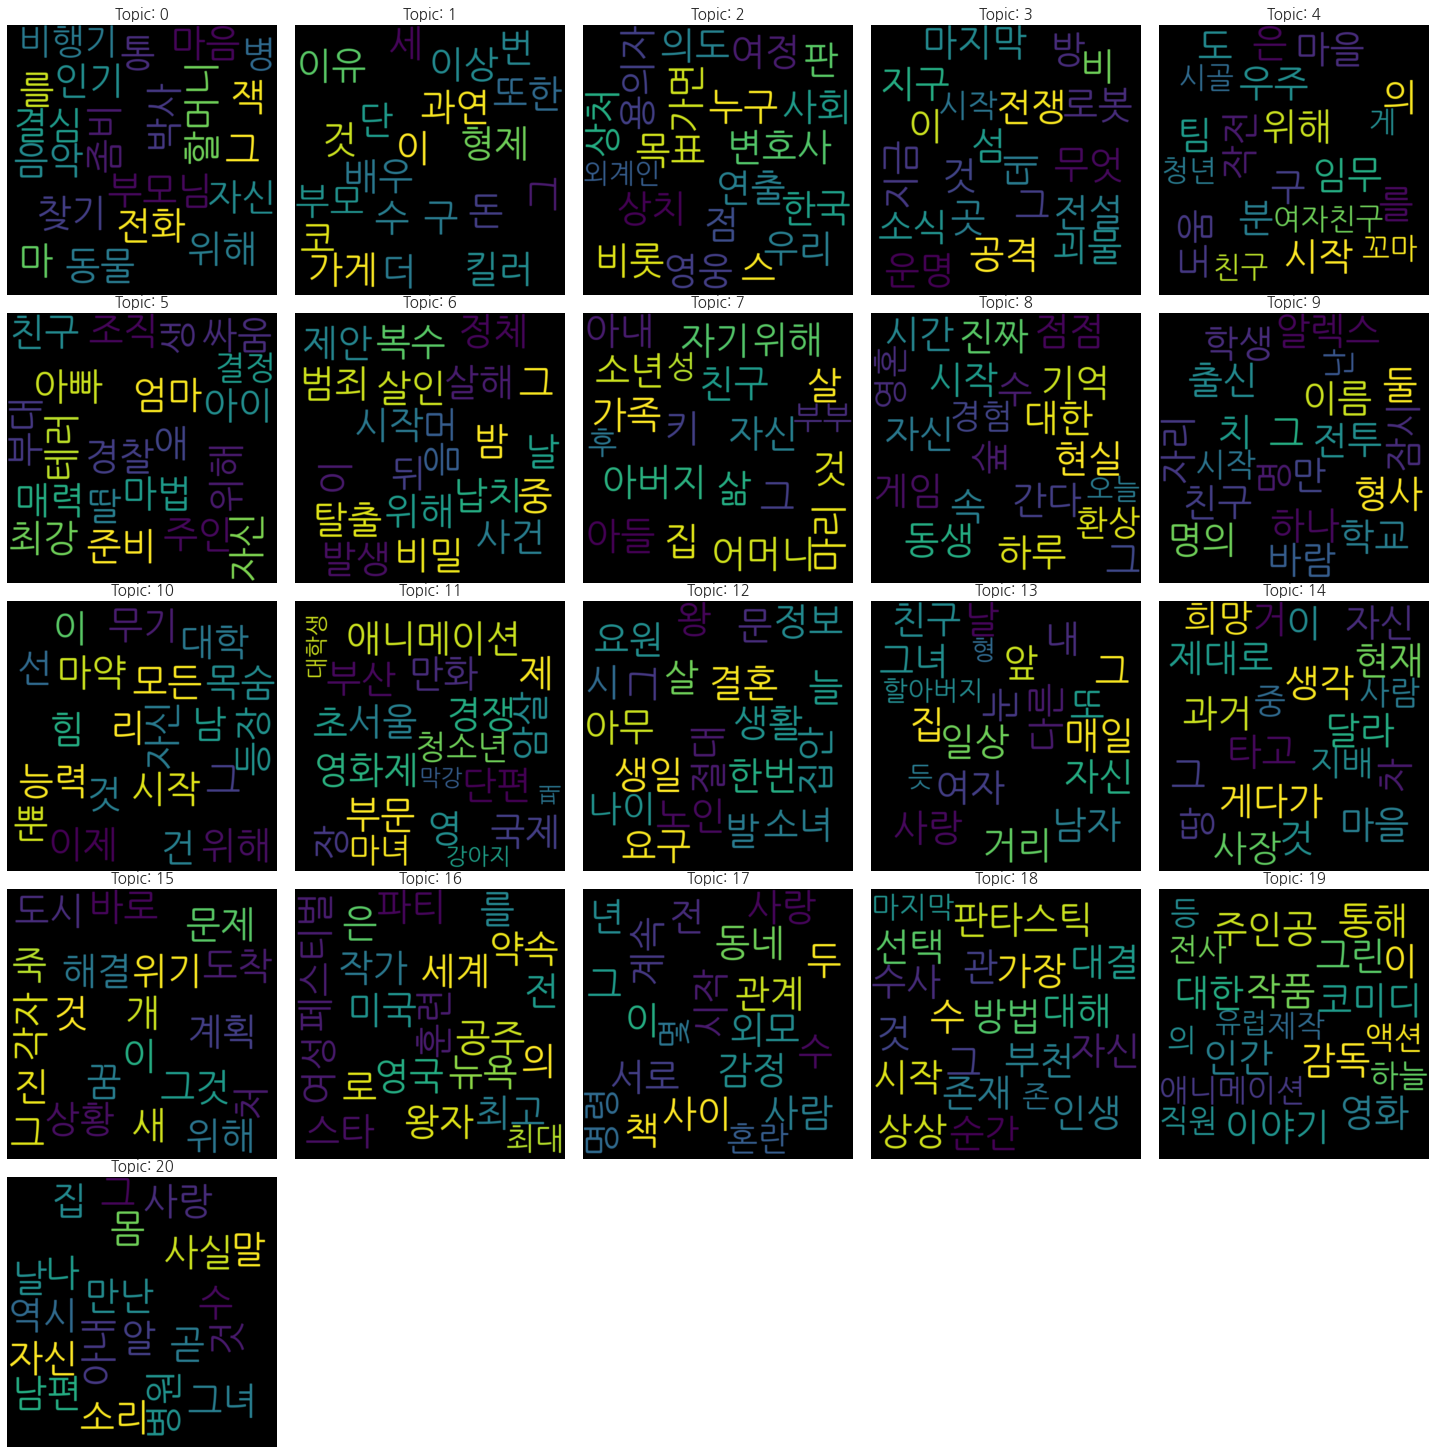

In [215]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 워드클라우드를 그릴 수 있는 레이아웃 크기 설정
num_rows = 5
num_cols = 5

# Figure 크기 설정
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

# 각 subplot에 워드클라우드 그리기
for topic_id, topic in enumerate(lda_model.print_topics(num_topics=num_topics, num_words=20)):
    topic_words = " ".join([word.split("*")[1].strip() for word in topic[1].split(" + ")])
    wordcloud = WordCloud(width=800, height=800, random_state=21, max_font_size=110, font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf').generate(topic_words)
    
    ax = axes[topic_id // num_cols, topic_id % num_cols]
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")
    ax.set_title("Topic: {}".format(topic_id), fontsize=15)

# 빈 subplot 처리
for i in range(len(lda_model.print_topics(num_topics=num_topics, num_words=20)), num_rows * num_cols):
    ax = axes[i // num_cols, i % num_cols]
    ax.axis("off")

plt.tight_layout(pad=0)
plt.show()


- topic 7 : 가족영화처럼 보인다
- topic 11, 18 : 애니메이션, 영화제, 부천 판타스틱 영화제 등 예술 영화 관련 내용들로 보인다

## 예술영화와 일반영화

In [131]:
art_gen_docs = [' '.join(t) for text in art_gen_texts for t in text]

In [148]:
# 상위 1,000개의 단어를 보존 
ag_vectorizer = TfidfVectorizer(max_features= 1000)
ag_X = ag_vectorizer.fit_transform(art_gen_docs)

# TF-IDF 행렬의 크기 확인
print('TF-IDF 행렬의 크기 :', ag_X.shape)

TF-IDF 행렬의 크기 : (112972, 1000)


In [149]:
lda_model = LatentDirichletAllocation(n_components=2,learning_method='online',random_state=777, max_iter=1)

In [150]:
lda_top = lda_model.fit_transform(ag_X)

In [151]:
print(lda_model.components_)
print(lda_model.components_.shape)

[[284.29283199 115.48123498  25.02160596 ... 113.24169998 295.68400949
    1.75070307]
 [  3.012232     0.68985692 179.25626165 ...   7.19839736   0.96478399
  187.34417675]]
(2, 1000)


In [152]:
# 단어 집합. 1,000개의 단어가 저장됨.
terms = ag_vectorizer.get_feature_names()
get_topics(lda_model.components_, terms, n=10)

Topic 1: ['그녀', '자신', '사람', '사랑', '남자', '시작', '아이', '가족', '남편', '아버지']
Topic 2: ['영화제', '영화', '국제', '이야기', '대한', '감독', '작품', '위해', '친구', '서울']


## 결론
- 결론적으로 이번 task는 시놉시스도 부족하고 일반영화와 예술영화의 label의 문제도 있을 것이고 데이터도 단어의 양적인 측면에서 일반영화의 데이터가 훨씬 많고, 예술영화가 그에 비해 반도 안되는 용량이였기에 데이터도 불균형 한 문제가 있다
- tf-idf의 결과가 우리의 직관과 유사한 결론이 나왔지만 이 결과도 사실 이미 일반 영화의 키워드에 '다큐멘터리','섹스'등 특정 장르를 지칭하는 단어들이 존재하였고, 이에 따라 나온 결과로 볼 수 있다
- 더 많은 데이터셋으로 장르를 대표할 수 있을 키워드를 찾는 것이 더 합당한 결론이 나올 것으로 보인다

# 회고
- 배운 점 
    - 기존에 배웠던 토픽 모델링을 적용해보고 나아가 bertopic도 해봤다
- 아쉬운 점 
    - 좀 더 체계적으로 비교를 해보고 싶었는데 시간상의 이유로 제대로 비교해보지 못해서 아쉽다
    - 생각보다 좋은 결과가 나오지 않아서 아쉽다
- 느낀 점
    - 시간이 너무 오래걸리고 내 가정과 비슷한 결론을 가져가는 것은 쉽지 않다
    - 더 많은 데이터가 필요하다
- 어려웠던 점 
    - 커널이 죽지 않게 잘 관리하는 것이 어렵다